In [103]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange

In [68]:
#path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#/Ti scope/2023_11_28/2023_11_28_10x_1.0x_pAAA_Ti_Pos6.ome.tif

In [69]:
scope_name = 'Tweez scope'
#scope_name = 'Ti scope'
path_scope = os.path.join(path_ext, scope_name)
exp_date = '2023_12_08'
path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
vector = 'pLPT20&pLPT41'
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [70]:
exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
i = exp_sum[(exp_sum.formatted_dates == exp_date) & (exp_sum.Machine == scope_name)].index[0]

In [104]:
exp_sum

,Date,Machine,Strain,DNA,Chemical,Dilution,formatted_dates
0,2023-12-08,Tweez scope,MC4100,pLPT20&pLPT41,aTc,10^(-5),2023_12_08


In [74]:
positions = pd.read_excel('../Notebooks/Positions.xlsx')

In [77]:
df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name)]# & 
        #(positions.Quality == 'Very good')]
df_pos.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,Quality,exp length,Colonies,Centers,Radius,radj
240,2023-12-08,Tweez scope,0,MC4100,pLPT20&pLPT41,ATC-,1,10^(-5),14:18:00,19:07:00,Very good,406,1.0,"515, 510",70.0,30.0
241,2023-12-08,Tweez scope,1,MC4100,pLPT20&pLPT41,ATC-,1,10^(-5),14:18:00,19:07:00,Very good,406,1.0,"515, 510",100.0,20.0
242,2023-12-08,Tweez scope,2,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,Very good,406,1.0,"510, 505",70.0,50.0
243,2023-12-08,Tweez scope,3,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,Good,406,2.0,NaN,NaN,NaN
244,2023-12-08,Tweez scope,4,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,Very good,406,1.0,"510, 510",100.0,50.0


In [78]:
poss = df_pos.Position.unique()
poss

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [ ]:
#tincub = 289

pos0


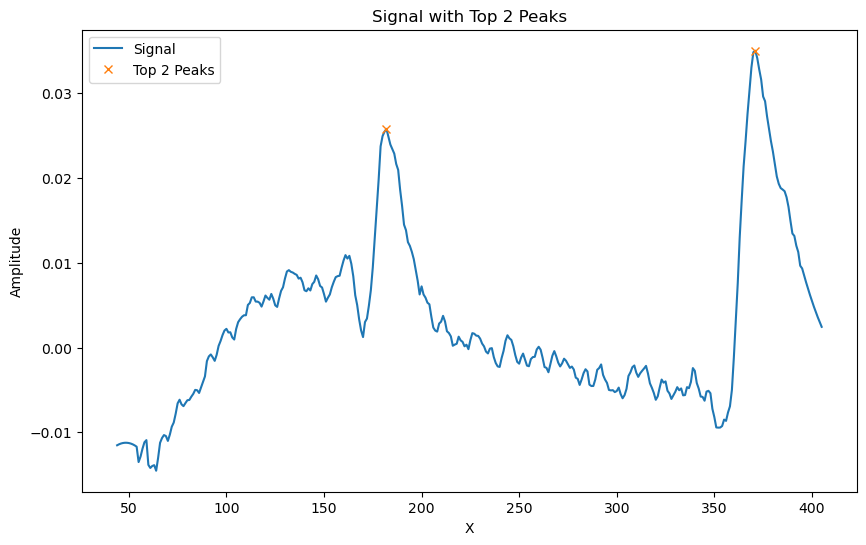

pos1


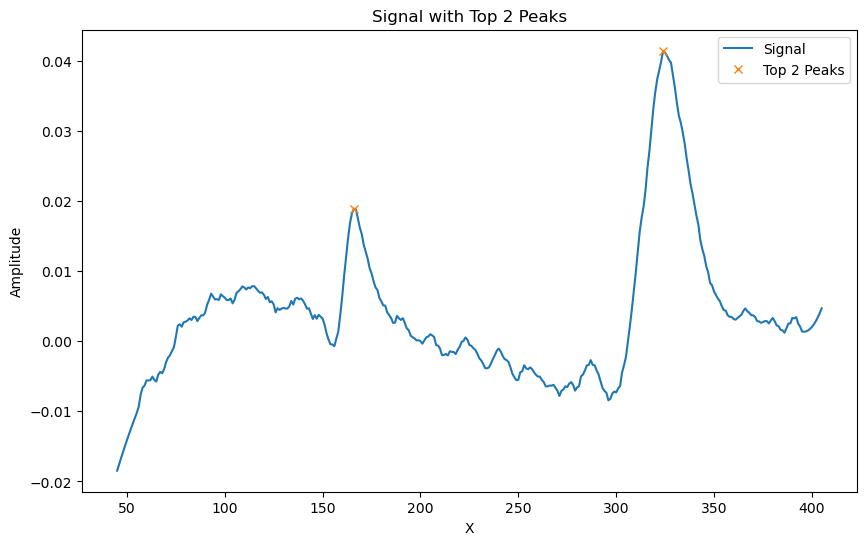

pos2


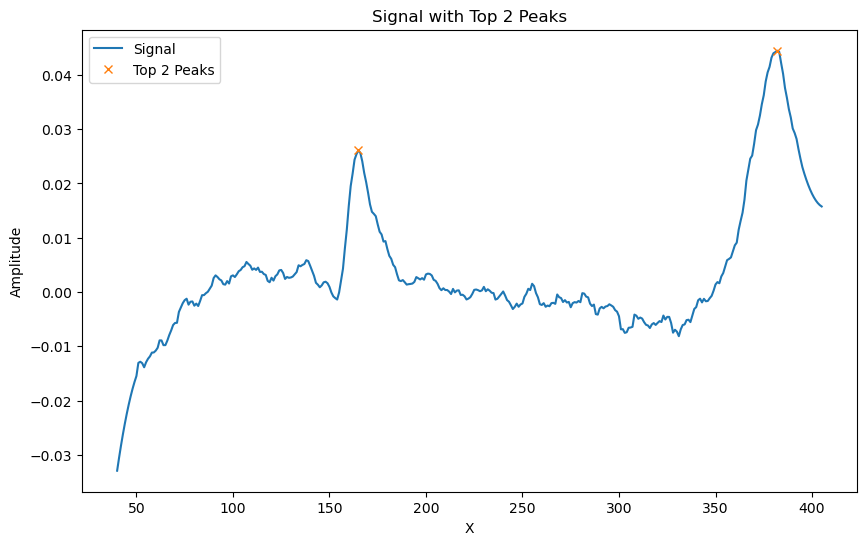

pos3


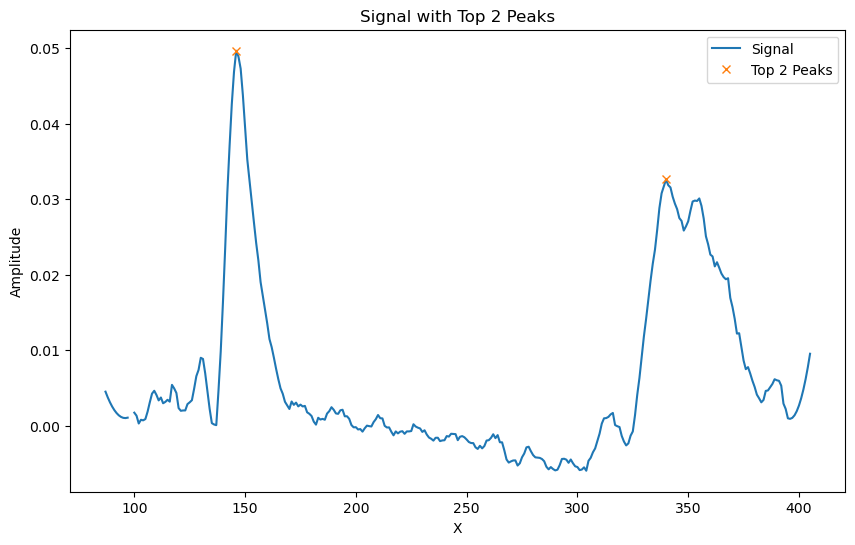

pos4


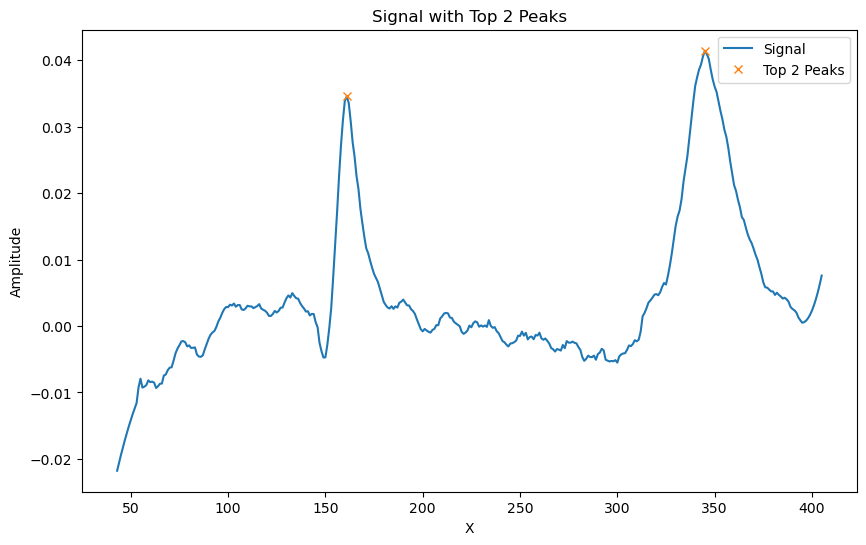

pos5


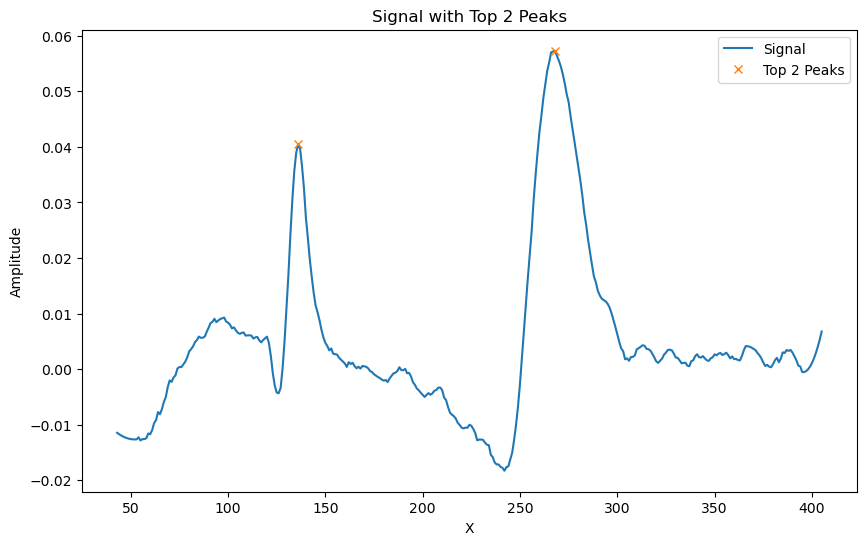

pos6


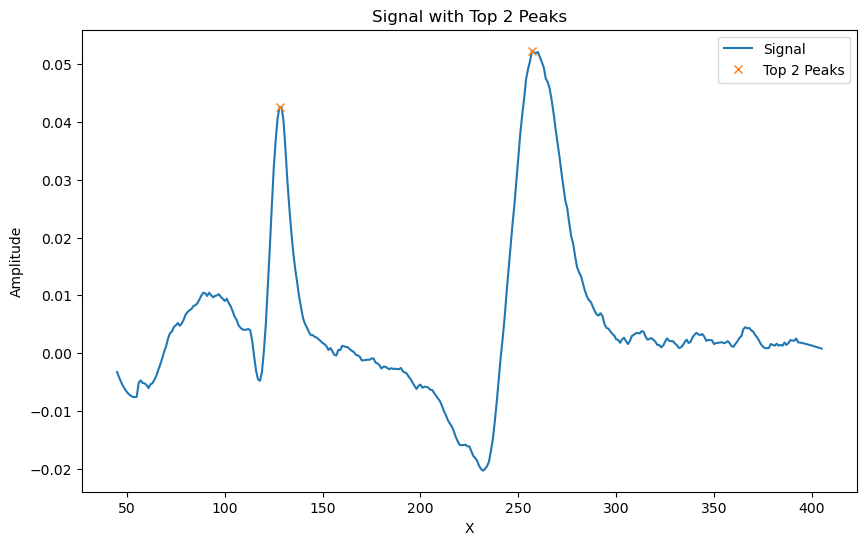

pos7


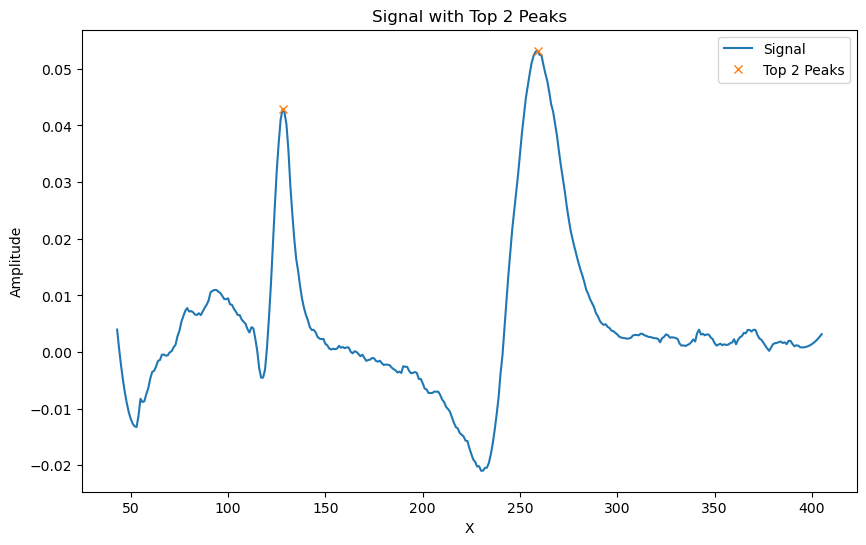

pos8


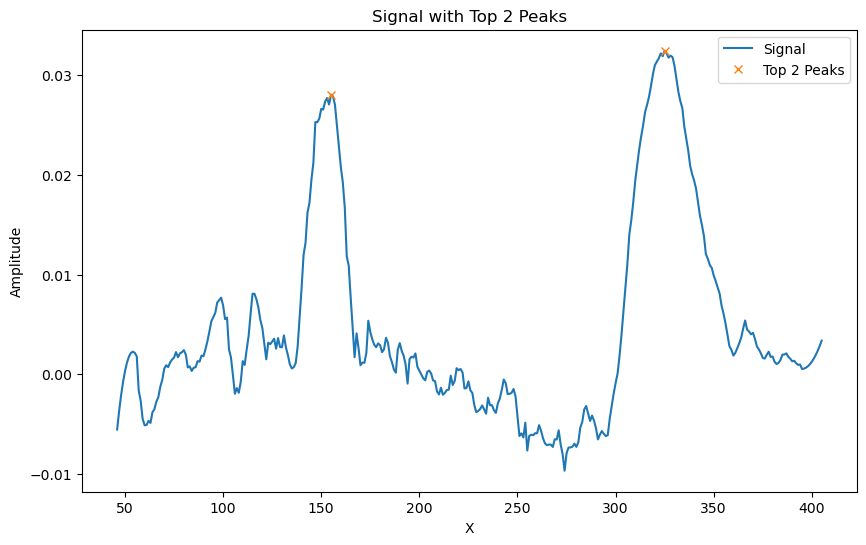

pos9


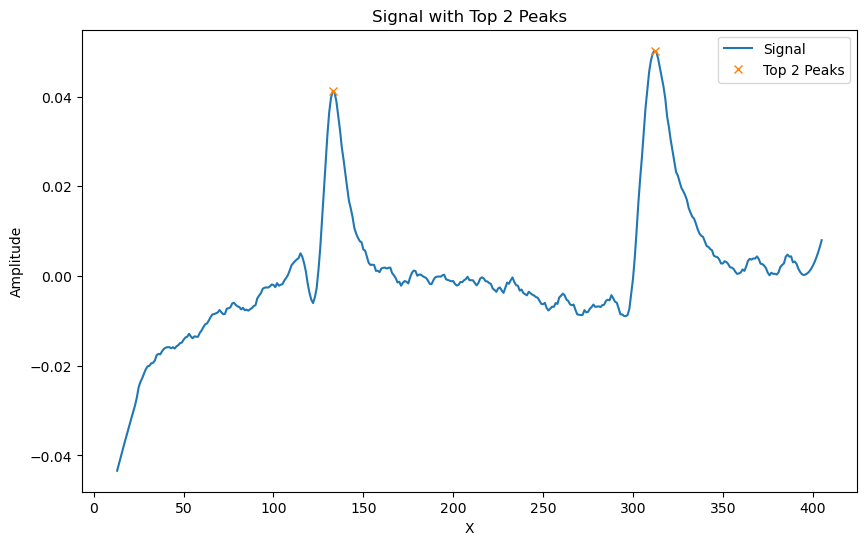

pos10


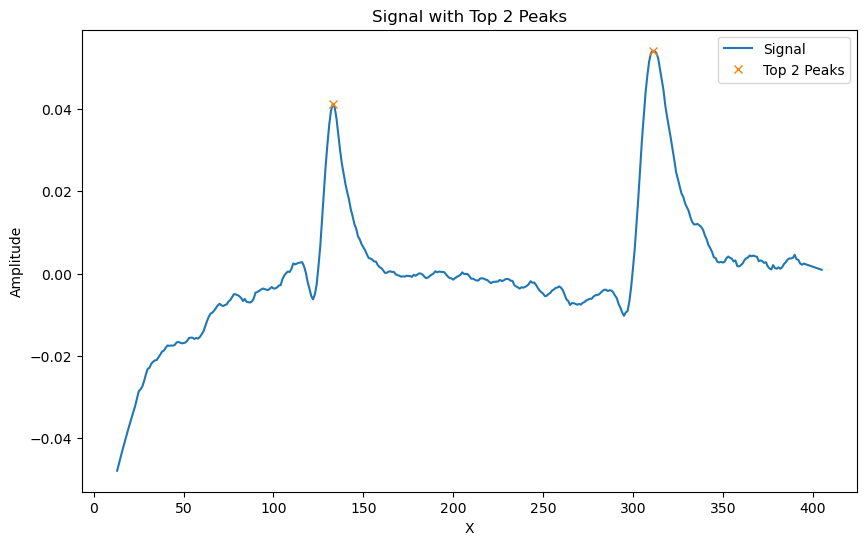

pos11


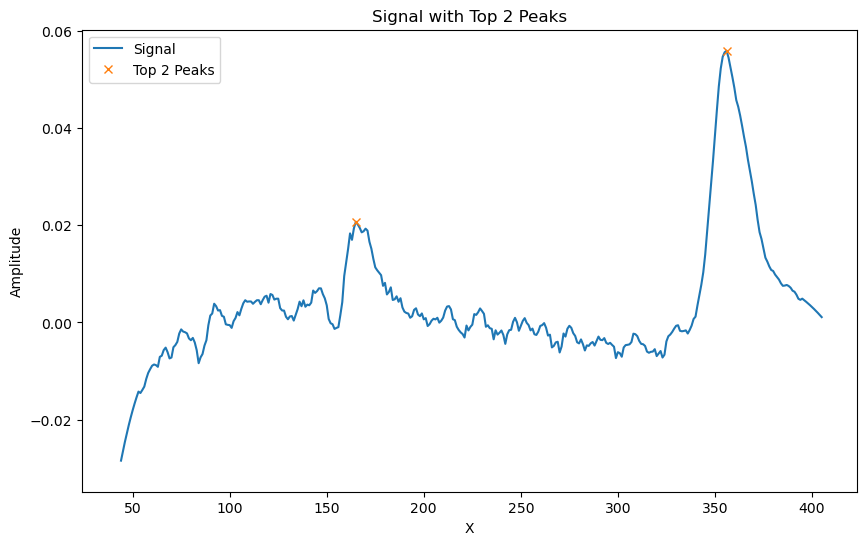

pos12


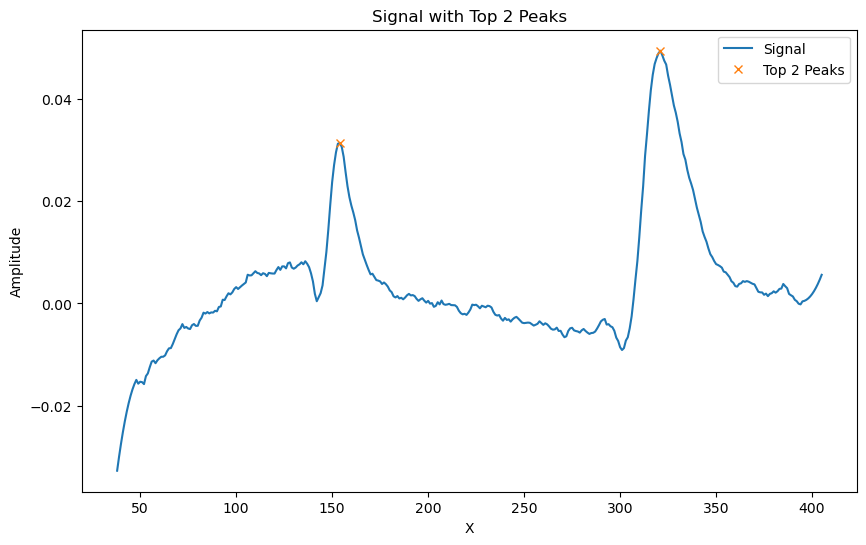

pos13


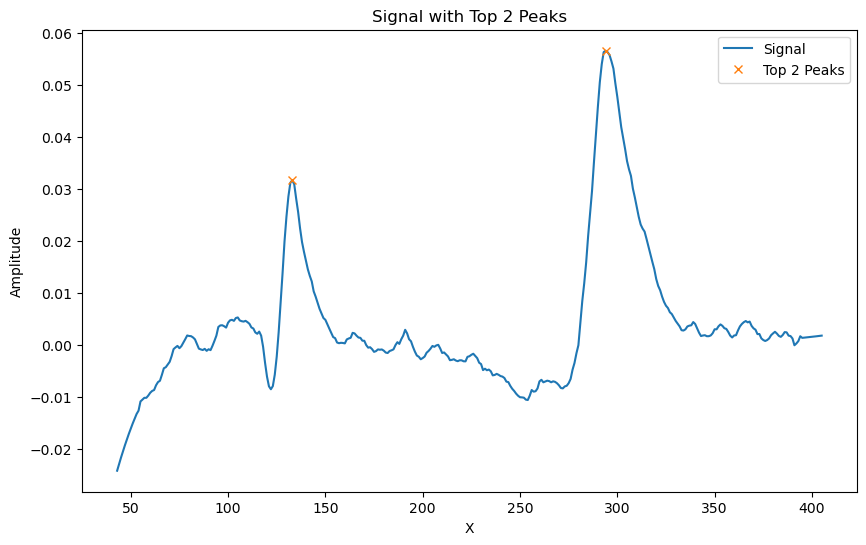

In [107]:
wave_arr = np.zeros((14,2))
dlrhos_center = np.zeros((14, 406, 2))
for i, pos in enumerate(range(14)):
    print(f"pos{i}")
    dlrhos_center[i,:,:] = np.load(os.path.join(path_ext,scope_name,exp_date,folder_results,f"pos{pos}", 'dlrho_center.npy'))
    dlrhos = dlrhos_center[i,:,:]
    t = np.arange(406)
    signal = dlrhos
    peaks, properties = find_peaks(dlrhos[:,0], height=-0.04, prominence=0.005)  # Adjust parameters based on your signal
    
    sorted_indices = np.argsort(properties['peak_heights'])[-2:]  # Get indices of the top 2 peaks by height
    top_peaks = peaks[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, dlrhos[:,0], label='Signal')
    plt.plot(t[top_peaks], dlrhos[top_peaks,0], "x", label='Top 2 Peaks')
    plt.title('Signal with Top 2 Peaks')
    plt.xlabel('X')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    wave_arr[pos,:] = t[top_peaks]

In [98]:
mask = imread('/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Tweez scope/2023_12_08/contour_masks/mask_2023_12_08_10x_1.0x_pLPT20&41_TiTweez_Pos10.ome.tif')

In [108]:
wave_arr

array([[182., 371.],
       [166., 324.],
       [165., 382.],
       [340., 146.],
       [161., 345.],
       [136., 268.],
       [128., 257.],
       [128., 259.],
       [155., 325.],
       [133., 312.],
       [133., 311.],
       [165., 356.],
       [154., 321.],
       [133., 294.]])

In [57]:
nt,nc = 398, 3
mean = np.zeros((npos,nt,nc))
rho = np.zeros((npos,nt,nc-1))
lrho = np.zeros((npos,nt,nc-1))
dlrho = np.zeros_like(lrho) + np.nan

In [ ]:
for pos in poss:
    print(f"Pos {pos}")
    fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
    print(fname)
    path_im = os.path.join(path, fname)
    path_results = os.path.join(path, folder_results, f"pos{pos}")
    im_all = imread(path_im)
    im_all = im_all[:,:,:,:ph_chn]
    nt,nx,ny,nc = im_all.shape    
    path_results = os.path.join(path, folder_results, f"pos{pos}")
    edt = np.load(os.path.join(path_results,'edt.npy'))
    edt = edt[:,:,:]

    bg = np.zeros((nc,))
    for c in range(nc):
        bg[c] = im_all[0,:100,:100,c].mean()
    
    rw = 16
    Rmax = edt.max()    
    for t in range(nt):    
        tedt = edt[t,:,:]
        idx = tedt > Rmax - rw        
        if np.sum(idx)>0:
            if fluo_chns == 3:
                ntim0 = im_all[t,:,:,rfp_chn].astype(float) - bg[rfp_chn]
                ntim1 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
                ntim2 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]
                x,y,z = ntim0[idx], ntim1[idx], ntim2[idx]
                mean[pos,t,rfp_chn] = x.mean()
                mean[pos,t,yfp_chn] = y.mean()
                mean[pos,t,cfp_chn] = z.mean()            
            elif fluo_chns == 2:                
                ntim0 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
                ntim1 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]               
                x,y = ntim0[idx], ntim1[idx]
                mean[pos,t,yfp_chn] = x.mean()
                mean[pos,t,cfp_chn] = y.mean()
    
    rho[pos,:,0] = mean[pos,:,0] / mean[pos,:,2]
    rho[pos,:,1] = mean[pos,:,1] / mean[pos,:,2]
    lrho[pos,:,:] = np.log(rho[pos,:,:])
    dlrho[pos,:,:] = savgol_filter(lrho[pos,:,:], 21, 3, deriv=1, axis=0)

Pos 0
2023_12_08_10x_1.0x_pLPT107&41_Ti_Pos0.ome.tif


/tmp/ipykernel_360475/848722237.py:40: RuntimeWarning: invalid value encountered in divide
  rho[pos,:,0] = mean[pos,:,0] / mean[pos,:,2]
/tmp/ipykernel_360475/848722237.py:41: RuntimeWarning: invalid value encountered in divide
  rho[pos,:,1] = mean[pos,:,1] / mean[pos,:,2]


Pos 1
2023_12_08_10x_1.0x_pLPT107&41_Ti_Pos1.ome.tif
